In [1]:
import numpy as np
import pandas
import pandas as pd


import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.cm as cm

import copy

import cvxpy as cp
from mpl_toolkits.mplot3d import Axes3D
import multiprocessing 
from multiprocessing import Process, Manager
import time
import big_o

import SynergisDataUtils
from IVutils import *

import scipy.stats as stats
from scipy import optimize
from scipy.stats import lognorm
from scipy.stats import norm

from scipy.interpolate import RectBivariateSpline
from scipy.interpolate import Rbf
from scipy.sparse import diags
from scipy.interpolate import interp1d
from scipy.interpolate import interp2d
from scipy.interpolate import PchipInterpolator


from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score



from colorspacious import cspace_converter
from collections import OrderedDict
cmaps = OrderedDict()

from scipy.interpolate import BSpline

import pickle

plt.rcParams["figure.figsize"] = (12,6)

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid

def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

In [3]:
def implied_volatility_v(pp, ss0, kk, ttau, qq):
    res = np.zeros(len(pp))
    for i in range(len(res)):
        res[i] = implied_volatility(price=pp[i], F=ss0[i], K=kk[i], T=ttau[i], q=qq[i])
    res = np.maximum(1e-14,np.minimum(3,res))
    res[np.argwhere(res==10).flatten()] = 1e-14
    return res

In [4]:
def measure_time(s, n=20):
    res = 0
    for k in range(n):
        start_time = time.time()
        exec(s)
        end_time = time.time()
        res += end_time-start_time
    print("time elapsed = {} s".format(res/n))

# ------ ------ ------ ------ ------ ------ ------ ------ ------ ------
# ------ ------ ------ ------ ------ ------ ------ ------ ------ ------
# ------ ------ ------ ------ ------ ------ ------ ------ ------ ------
# Data


In [5]:
df_load = pandas.read_csv("csvFiles/AAPLOptionsData_from=2018-05-15_to=2020-05-15.csv")
df = df_load[["option_type", "strike", "ask", "underlying_ask", "underlying_bid"]].copy()
df.insert(0,"quote_datetime",df_load["quote_datetime"].astype("datetime64"))
df.insert(2,"expiration",df_load["expiration"].astype("datetime64"))
df = df[df.quote_datetime.dt.hour==16]
df["days_to_expiry"] = np.busday_count(df["quote_datetime"].values.astype('datetime64[D]'),
                                       df["expiration"].values.astype('datetime64[D]'))
df["underlying_mid"] = (df["underlying_ask"]+df["underlying_bid"])/2
df["moneyness"] = df["strike"]/df["underlying_mid"]
df = df.reset_index(drop=True).sort_values(["quote_datetime", "days_to_expiry", "strike"])

df_stock = (df[["quote_datetime", "underlying_mid"]]
            .drop_duplicates()
            .sort_values(["quote_datetime"])
            .reset_index(drop=True))
trading_days = df.quote_datetime.drop_duplicates().sort_values().reset_index(drop=True)

# ------ ------ ------ ------ ------ ------ ------ ------ ------ ------
# ------ ------ ------ ------ ------ ------ ------ ------ ------ ------
# ------ ------ ------ ------ ------ ------ ------ ------ ------ ------
# Functions

In [6]:
class backtest:
    def __init__(self, df):
        self.trading_days = df.quote_datetime.drop_duplicates().sort_values().reset_index(drop=True).copy()
        self.strategy = {}
        self.contract_keys = []
        self.df = df.copy()
        self.df_day = df[df['quote_datetime']== df.at[df.index[0],'quote_datetime']]
        self.portfolios = {d:{} for d in self.trading_days}
        self.constraints = {}
        self.options_buckets = {}
        self.masks = []
        self.groups_keys = []
        
        self.pnl_buckets = {}
    
    
    def initialize_pnl_buckets(self):
        dte_grid = np.array([  
            0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
            13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
            26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
            39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
            52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
            65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
            78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
            91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
            104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
            117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
            130
        ])
        
        delta_call_grid = np.array([
            0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22, 0.23, 0.24, 0.25,
            0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33, 0.34, 0.35, 0.36,
            0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44
        ])
        delta_put_grid = np.array([
            -0.15, -0.16, -0.17, -0.18, -0.19, -0.2 , -0.21, -0.22, -0.23,
            -0.24, -0.25, -0.26, -0.27, -0.28, -0.29, -0.3 , -0.31, -0.32,
            -0.33, -0.34, -0.35, -0.36, -0.37, -0.38, -0.39, -0.4 , -0.41,
            -0.42, -0.43, -0.44
        ])
        
        for dte in dte_grid:
            for delta_call in delta_call_grid:
                for delta_put in delta_put_grid:
                    self.pnl_buckets[(dte, delta_call, delta_put)] = []
                
    

    def add_option(self, key, quantity, user_trading_rules=""):
        """
        :method: add a contract to the strategy
        :param key: string to identify the added contract
        :param quantity: quantity to buy or sell (positive or negative)
        :param trading_rule: string, user input in the format "strike > 4, feature operation value, …"
        :return: none
        """
        self.contract_keys.append(key)
        trading_rules = []
        if len(user_trading_rules) != 0:
            trading_rules = user_trading_rules.split(", ")
        self.strategy[key] = {
            "quantity": quantity,
            "trading_rules": trading_rules
        }
    
    def select_data(self, rules):
        """
        :method: selects data according to rules
        :param rules: list of strings, each string has the format "feature operation value"
        :return: indices of selected options in self.df/self.df_day
        """
        s = ""
        for r in rules:
            if s != "":
                s += " & "
            feature, operation, value = r.split(" ")
            if feature == "option_type":
                value = "'{}'".format(value)
            s += "(self.df_day['{}'] {} {})".format(feature, operation, value)
        return eval("self.df_day[{}].index".format(s))
    
    def initialize_constraints(self):
        """
        warning! all contracts of the strategy must have been added
        :method: create a dictionary of mutual constraints between contracts of the strategy
        """
        self.constraints = {x:{y:[] for y in self.contract_keys if y != x} for x in self.contract_keys}
    
    def add_constraints(self, user_constraints):
        """
        :method: add contraints between contracts of the strategy
        :param user_constraints: string in the format "key_1.feature_1 operation key_2.feature_2, …"
        :return: none
        """
        reverse_operations = {
        ">": "<",
        "==": "==",
        "<": ">",
        ">=": "<=",
        "<=": ">="
        }
        for const in user_constraints.split(", "):
            e1, o, e2 = const.split(" ")
            key1, feature1 = e1.split(".")
            key2, feature2 = e2.split(".")
            self.constraints[key1][key2].append({"feature_self": feature1, 
                                                 "operation": o, 
                                                 "feature_other": feature2})
            self.constraints[key2][key1].append({"feature_self": feature2, 
                                                 "operation": reverse_operations[o], 
                                                 "feature_other": feature1})
    
    
    def add_masks(self, user_masks):
        """
        :method: add a common condition across all contracts of the strategy
        :param user_masks: string in the format "feature operation value, …"
        """
        for mask in user_masks.split(", "):
            self.masks.append(mask)
    
    
    def add_groups(self, user_group):
        """
        :method: add a feature that has to be common across all contracts of the strategy
        :param user_group: string in the format "feature operation value, …"
        """
        for feature in user_group.split(", "):
            self.groups_keys.append(feature)
    
    def set_day(self, day):
        """
        :method: selects the sub-dataframe that corresponds to the chosen day, filtered by masks,
                 sets the value of df_days
        """
        m = "(self.df['quote_datetime']==day)"
        for mask in self.masks:
            m += " & "
            feature, operation, value = mask.split(" ")
            if feature == "option_type":
                value = "'{}'".format(value)
            m += "(self.df['{}'] {} {})".format(feature, operation, value)
        self.df_day = eval("self.df[{}]".format(m))
    
    
    def set_buckets(self, group_key_value):
        """
        :method: sets the buckets candidates contracts, satisfying the strategy
        """
        self.options_buckets = {}
        
        rule_group = []
        for i_group, key in enumerate(self.groups_keys):
            rule_group.append("{} == {}".format(key, group_key_value[i_group]))
        
        for key in self.contract_keys:
            rules = rule_group + self.strategy[key]["trading_rules"] 
            self.options_buckets[key] = self.select_data(rules)
    
    

    def bt(self, day, group_key_value, pf=[], i_key=0):
        """
        :method: compute all possible portfolios satisfying the strategy, among contracts in buckets
        """
        k = self.contract_keys[i_key]
        for i_option in self.options_buckets[k]:
            condition = True
            for index_pf, i_pf in enumerate(pf):
                for const in self.constraints[k][self.contract_keys[index_pf]]:
                    test = eval("self.df.at[{},'{}'] {} self.df.at[{}, '{}']".format(
                        i_option,
                        const["feature_self"], 
                        const["operation"], 
                        i_pf,
                        const["feature_other"])
                    )
                    if not test:
                        condition = False
                        break
                if not condition:
                    break
            if condition:
                pf.append(i_option)
                if i_key == len(self.contract_keys)-1:
                    self.portfolios[day][group_key_value].append(pf.copy())
                else:
                    self.bt(day, group_key_value, pf, i_key+1)
                pf.pop()
                
    def find_entry(self):
        """
        iterate trading day → filter by masks → iterate groups → filter by trading rules
            → run backtest on resulting contract buckets → save portfolios in portfolios' dictionary
        """
        for day in self.trading_days:
            print(day)
            self.set_day(day)
            for group_key_value in (self.df_day[self.groups_keys]
                                    .drop_duplicates()
                                    .itertuples(index=False, name=None)):
                self.set_buckets(group_key_value)
                
                self.portfolios[day][group_key_value] = []
                self.bt(day, group_key_value)
                if len(self.portfolios[day][group_key_value])==0:
                    del self.portfolios[day][group_key_value]
    
    def compute_pnl(self):
        """
        :method: compute pnl of each portfolio in portfolios' dictionary
        """
        for key_day in self.portfolios.keys():
            for key_group in self.portfolios[key_day].keys():
                for i_pf, pf in enumerate(self.portfolios[key_day][key_group]):
                    res = 0
                    cost = 0
                    for i, i_option in enumerate(pf):
                        weight = self.strategy[self.contract_keys[i]]["quantity"]
                        res += weight * self.df.at[i_option, "PnL"]
                        cost += weight * self.df.at[i_option, "ask"]
                    self.portfolios[key_day][key_group][i_pf].append(cost)
                    self.portfolios[key_day][key_group][i_pf].append(res)
    
    
    def pnl_of_pf(self, pf):
        res = 0
        cost = 0
        for i, i_option in enumerate(pf):
            weight = self.strategy[self.contract_keys[i]]["quantity"]
            res += weight * self.df.at[i_option, "PnL"]
            cost += weight * self.df.at[i_option, "ask"]
        return res/cost
    
                    
                    
    def bt_buckets(self, day, group_key_value, pf=[], i_key=0):
        """
        :method: compute all possible portfolios satisfying the strategy, among contracts in buckets
        """
        k = self.contract_keys[i_key]
        for i_option in self.options_buckets[k]:
            condition = True
            for index_pf, i_pf in enumerate(pf):
                for const in self.constraints[k][self.contract_keys[index_pf]]:
                    test = eval("self.df.at[{},'{}'] {} self.df.at[{}, '{}']".format(
                        i_option,
                        const["feature_self"], 
                        const["operation"], 
                        i_pf,
                        const["feature_other"])
                    )
                    if not test:
                        condition = False
                        break
                if not condition:
                    break
            if condition:
                pf.append(i_option)
                if i_key == len(self.contract_keys)-1:
                    dte = self.df.at[pf[0], "days_to_expiry"]
                    delta_c = np.floor(self.df.at[pf[0], "delta"]*100)/100
                    delta_p = np.ceil(self.df.at[pf[1], "delta"]*100)/100
                    self.pnl_buckets[(dte, delta_c, delta_p)].append(self.pnl_of_pf(pf))
                else:
                    self.bt_buckets(day, group_key_value, pf, i_key+1)
                pf.pop()
                
    def find_entry_buckets(self):
        """
        iterate trading day → filter by masks → iterate groups → filter by trading rules
            → run backtest on resulting contract buckets → save portfolios in portfolios' dictionary
        """
        for day in self.trading_days:
            print(day)
            self.set_day(day)
            for group_key_value in (self.df_day[self.groups_keys]
                                    .drop_duplicates()
                                    .itertuples(index=False, name=None)):
                self.set_buckets(group_key_value)
                
                self.bt_buckets(day, group_key_value)

In [7]:
def find_stock_expiry(day, dte):
    index_current = df_stock[df_stock["quote_datetime"]==day].index[0]
    index_exp = index_current + int(dte)
    return df_stock.at[index_exp, "underlying_mid"]

# ------ ------ ------ ------ ------ ------ ------ ------ ------ ------
# ------ ------ ------ ------ ------ ------ ------ ------ ------ ------
# ------ ------ ------ ------ ------ ------ ------ ------ ------ ------

# Choose the dataframe and compute PnL of each options (hold until expiry)

Timestamp('2020-05-15 16:00:00')

In [12]:
import copy
d_max = copy.copy(trading_days.iloc[400])

# select trading days
#df1 = df[(df["quote_datetime"]<trading_days[23])&(df["quote_datetime"]>trading_days[20])].copy()
df1 = df[(df["quote_datetime"]<d_max)].copy()

# for each option, find the stock value at expiry 
for d in df1.quote_datetime.drop_duplicates().sort_values():
    for dte in df1[df1["quote_datetime"]==d].days_to_expiry.drop_duplicates():
        df1.loc[(df1.quote_datetime==d) & (df1.days_to_expiry==dte), 
                "underlying_at_expiry"] = find_stock_expiry(d, dte)

# compute PnL of call and puts
select_put = df1.option_type=='P'
df1.loc[select_put,'PnL'] = (np.maximum(df1[select_put].strike
                                        - df1[select_put].underlying_at_expiry, 0) 
                             - df1[select_put].ask)
select_call = df1.option_type=='C'
df1.loc[select_call,'PnL'] = (np.maximum(df1[select_call].underlying_at_expiry
                                         - df1[select_call].strike, 0) 
                              - df1[select_call].ask)

df1.drop('underlying_at_expiry', axis=1, inplace=True)


iv = implied_volatility_v(pp=df1.ask.values, 
                          ss0=df1.underlying_mid.values, 
                          kk=df1.strike.values, 
                          ttau=df1.days_to_expiry.values/252,
                          qq=[1 if df1.option_type.iloc[i]=="C" else -1 for i in range(len(df1.index))])

df1['delta'] = norm.cdf(((np.log(df1.underlying_mid.values/df1.strike.values)
                         + (iv**2*df1.days_to_expiry.values/252))
                         / iv*np.sqrt(df1.days_to_expiry.values/252)))
df1.loc[select_put, 'delta'] = df1.loc[select_put, 'delta']-1

In [ ]:
# plt.plot(np.sort(df1[df1.option_type=='P'].delta.values))

# Choose the option strategy

### strangle
A strangle is an options strategy where the investor holds a position in both a call and a put option with different strike prices, but with the same expiration date and underlying asset.

In a long strangle—the more common strategy—the investor simultaneously buys an out-of-the-money call and an out-of-the-money put option. The call option's strike price is higher than the underlying asset's current market price, while the put has a strike price that is lower than the asset's market price. This strategy has large profit potential since the call option has theoretically unlimited upside if the underlying asset rises in price, while the put option can profit if the underlying asset falls. The risk on the trade is limited to the premium paid for the two options.

In [13]:
res = backtest(df1)
res.add_option("c", 1, "option_type == C, delta > 0.15, delta < 0.45")
res.add_option("p", 1, "option_type == P, delta < -0.15, delta > -0.45")
res.initialize_constraints()
res.add_groups("days_to_expiry")
res.add_masks("days_to_expiry > 0, days_to_expiry < 80")


res.initialize_pnl_buckets()

In [ ]:
#print(res.trading_days)
print(res.strategy )
#print(res.contract_keys )
#print(res.df)
#print(res.portfolios)
#print(res.constraints)
#print(res.options_buckets)
#print(res.groups_keys)
#print(res.masks)
#print(res.pnl_buckets.keys())

# Run backtest

##### daily available portfolios

In [ ]:
#start_time = time.time()
#res.find_entry()
#res.compute_pnl()
#end_time = time.time()
#print("time elapsed = {} s".format(end_time-start_time))

##### PnL buckets

In [14]:
start_time = time.time()
res.find_entry_buckets()
end_time = time.time()
print("time elapsed = {} s".format(end_time-start_time))

2018-05-15 16:00:00
2018-05-16 16:00:00
2018-05-17 16:00:00
2018-05-18 16:00:00
2018-05-21 16:00:00
2018-05-22 16:00:00
2018-05-23 16:00:00
2018-05-24 16:00:00
2018-05-25 16:00:00
2018-05-29 16:00:00
2018-05-30 16:00:00
2018-05-31 16:00:00
2018-06-01 16:00:00
2018-06-04 16:00:00
2018-06-05 16:00:00
2018-06-06 16:00:00
2018-06-07 16:00:00
2018-06-08 16:00:00
2018-06-11 16:00:00
2018-06-12 16:00:00
2018-06-13 16:00:00
2018-06-14 16:00:00
2018-06-15 16:00:00
2018-06-18 16:00:00
2018-06-19 16:00:00
2018-06-20 16:00:00
2018-06-21 16:00:00
2018-06-22 16:00:00
2018-06-25 16:00:00
2018-06-26 16:00:00
2018-06-27 16:00:00
2018-06-28 16:00:00
2018-06-29 16:00:00
2018-07-02 16:00:00
2018-07-05 16:00:00
2018-07-06 16:00:00
2018-07-09 16:00:00
2018-07-10 16:00:00
2018-07-11 16:00:00
2018-07-12 16:00:00
2018-07-13 16:00:00
2018-07-16 16:00:00
2018-07-17 16:00:00
2018-07-18 16:00:00
2018-07-19 16:00:00
2018-07-20 16:00:00
2018-07-23 16:00:00
2018-07-24 16:00:00
2018-07-25 16:00:00
2018-07-26 16:00:00


# Print results

### strangle

In [15]:
pnl_bucket_size = {}
dte_grid = []
for k in list(res.pnl_buckets.keys()):
    if len(res.pnl_buckets[k])>0:
        pnl_bucket_size[k] = len(res.pnl_buckets[k])
        dte_grid.append(k[0])
    else:
        del res.pnl_buckets[k]

# Bucketing

##### Create maturity buckets

In [16]:
np.sort(np.unique(dte_grid))

array([11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
       28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
       45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61,
       62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78,
       79])

In [17]:
#DTE_BUCKET_SIZE = 10
#pnl_dte_buckets = {(DTE_BUCKET_SIZE*i, DTE_BUCKET_SIZE*(i+1)-1): {} for i in range(1,8)}


DTE_BUCKET_SIZE = 5
pnl_dte_buckets = {(DTE_BUCKET_SIZE*i, DTE_BUCKET_SIZE*(i+1)-1): {} for i in range(2,16)}

In [ ]:
print(pnl_dte_buckets)

##### Break down of the PnL

In [18]:
pnl_dte_buckets_size = {key: {} for key in list(pnl_dte_buckets.keys())}
mean_pnl_dte_buckets = {key: {} for key in list(pnl_dte_buckets.keys())}
std_pnl_dte_buckets =  {key: {} for key in list(pnl_dte_buckets.keys())}


for k in list(res.pnl_buckets.keys()):
    dte_bucket_key = (k[0]//DTE_BUCKET_SIZE*DTE_BUCKET_SIZE, (k[0]//DTE_BUCKET_SIZE+1)*DTE_BUCKET_SIZE-1)
    delta_bucket_key = (k[1], k[2])
    
    if delta_bucket_key in pnl_dte_buckets[dte_bucket_key].keys():
        pnl_dte_buckets[dte_bucket_key][(k[1], k[2])] += res.pnl_buckets[k]
        pnl_dte_buckets_size[dte_bucket_key][(k[1], k[2])] += len(res.pnl_buckets[k])
        
    else:
        pnl_dte_buckets[dte_bucket_key][(k[1], k[2])] = res.pnl_buckets[k]
        pnl_dte_buckets_size[dte_bucket_key][(k[1], k[2])] = len(res.pnl_buckets[k])
        
for k_dte in list(pnl_dte_buckets.keys()):
    for k_delta in list(pnl_dte_buckets[k_dte].keys()):
        mean_pnl_dte_buckets[k_dte][k_delta] = np.mean(pnl_dte_buckets[k_dte][k_delta])
        std_pnl_dte_buckets[k_dte][k_delta] = np.std(pnl_dte_buckets[k_dte][k_delta])

# PnL Charts

#####  Select a DTE bucket

In [19]:
pnl_dte_buckets.keys()

#mean_pnl_dte_buckets[key_dte]

dict_keys([(10, 14), (15, 19), (20, 24), (25, 29), (30, 34), (35, 39), (40, 44), (45, 49), (50, 54), (55, 59), (60, 64), (65, 69), (70, 74), (75, 79)])

##### plot the mean PnL on the delta grid

In [ ]:
vmax=500    
vmin=-100
ixc_min, ixc_max = 15, 45
ixp_min, ixp_max = 15, 45

In [ ]:
for i_dte, key_dte in enumerate(list(pnl_dte_buckets.keys())):
    pnl_grid = np.zeros((100,100))
    for key_delta in mean_pnl_dte_buckets[key_dte]:
        ix_delta_call = int(key_delta[0]*100)
        ix_delta_put  = int(abs(key_delta[1])*100)
        pnl_grid[ix_delta_call, ix_delta_put] = mean_pnl_dte_buckets[key_dte][key_delta]*100
    
    mask_grid = pnl_grid == 0
    
    pnl_grid_plot = eval("pnl_grid[{}:{},{}:{}]".format(ixc_min, ixc_max, ixp_min, ixp_max))
    mask_plot = eval("mask_grid[{}:{},{}:{}]".format(ixc_min, ixc_max, ixp_min, ixp_max))
    
    pnl_grid_plot = np.ma.array(pnl_grid_plot, mask=mask_plot)

    
    
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111)
    
    cmap = copy.copy(shiftedColorMap(cm.RdYlGn, 
                                     midpoint=100/(vmax+abs(vmin)), 
                                     name='shrunk'))
    cmap.set_bad()
    
    plt.imshow(pnl_grid_plot, aspect="auto", 
               cmap=cmap, vmin=vmin,vmax=vmax,
               origin='lower', 
               extent=(0, pnl_grid_plot.shape[0], 0, pnl_grid_plot.shape[1]))
    
    cbar = plt.colorbar(format=mtick.PercentFormatter())
    cbar.set_label('mean PnL', rotation=270, labelpad=20)
    
    ax.set_xticks(np.arange(pnl_grid_plot.shape[0]+1))
    ax.set_xticklabels(("0.%s"% i for i in np.arange(ixc_min, ixc_max+1)))
    ax.set_yticks(np.arange(pnl_grid_plot.shape[1]+1))
    ax.set_yticklabels(("-0.%s"% i for i in np.arange(ixc_min, ixc_max+1)))
    
    plt.xlabel("delta call")
    plt.ylabel("delta put")
    plt.title("DTE bucket {}".format(key_dte))
    

##### PnL Charts of Delta Buckets

In [20]:
pnl_dte_delta_buckets = {}
pnl_dte_delta_buckets_size = {}
mean_pnl_dte_delta_buckets = {}
std_pnl_dte_delta_buckets = {}

# initialize the delta buckets and their size
for key_dte in list(pnl_dte_buckets.keys()):
    pnl_dte_delta_buckets[key_dte] = {}
    pnl_dte_delta_buckets_size[key_dte] = {}
    mean_pnl_dte_delta_buckets[key_dte] = {}
    std_pnl_dte_delta_buckets[key_dte] = {}
    for delta_c in np.round(np.arange(0.15,0.45,0.03), 2):
        for delta_p in np.round(np.arange(-0.15,-0.45,-0.03), 2):
            key_delta_bucket = (
                (delta_c, round(delta_c+0.03,2)), 
                (delta_p, round(delta_p-0.03,2))
            )
            pnl_dte_delta_buckets[key_dte][key_delta_bucket] = []
            pnl_dte_delta_buckets_size[key_dte][key_delta_bucket] = 0
            mean_pnl_dte_delta_buckets[key_dte][key_delta_bucket] = 0
            std_pnl_dte_delta_buckets[key_dte][key_delta_bucket] = 0
            

# dispatch the pnl to relevant delta buckets
for key_dte in list(pnl_dte_buckets.keys()):
    for key_delta in pnl_dte_buckets[key_dte]:
        key_delta_bucket = (
            (round((key_delta[0]*100)//3*3/100,2), round(((key_delta[0]*100)//3+1)*3/100,2)),
            (round(-((abs(key_delta[1])*100)//3*3/100),2), round(-((int(abs(key_delta[1])*100)//3+1)*3/100),2))
        )
        
        pnl_dte_delta_buckets[key_dte][key_delta_bucket] += pnl_dte_buckets[key_dte][key_delta]
        pnl_dte_delta_buckets_size[key_dte][key_delta_bucket] += len(pnl_dte_buckets[key_dte][key_delta])

for key_dte in list(pnl_dte_delta_buckets.keys()):
    for key_delta_buckets in list(pnl_dte_delta_buckets[key_dte].keys()):
        if len(pnl_dte_delta_buckets[key_dte][key_delta_buckets])==0:
            del pnl_dte_delta_buckets[key_dte][key_delta_buckets]
            del pnl_dte_delta_buckets_size[key_dte][key_delta_buckets]
            del mean_pnl_dte_delta_buckets[key_dte][key_delta_buckets]
            del std_pnl_dte_delta_buckets[key_dte][key_delta_buckets]
        else:
            mean_pnl_dte_delta_buckets[key_dte][key_delta_buckets] = np.mean(
                pnl_dte_delta_buckets[key_dte][key_delta_buckets]
            )
            std_pnl_dte_delta_buckets[key_dte][key_delta_buckets] = np.std(
                pnl_dte_delta_buckets[key_dte][key_delta_buckets]
            )

##### One chart

In [ ]:
dte_key = (20,24)
delta_buckets_plot = np.array([str(x) for x in list(mean_pnl_dte_delta_buckets[dte_key].keys())])
mean_pnl_plot = np.zeros(len(delta_buckets_plot))
std_pnl_plot = np.zeros(len(delta_buckets_plot))

for i, key_delta_bucket in enumerate(list(mean_pnl_dte_delta_buckets[dte_key])):
    mean_pnl_plot[i] = mean_pnl_dte_delta_buckets[dte_key][key_delta_bucket]
    std_pnl_plot[i] = std_pnl_dte_delta_buckets[dte_key][key_delta_bucket]

delta_buckets_plot = delta_buckets_plot[np.argsort(mean_pnl_plot)][-10:]
std_pnl_plot = std_pnl_plot[np.argsort(mean_pnl_plot)][-10:]
mean_pnl_plot = np.sort(mean_pnl_plot)[-10:]

In [ ]:
width=0.8
plt.bar(delta_buckets_plot, mean_pnl_plot*100, yerr=std_pnl_plot*100, width=width, color='b', label='Mean PnL')
plt.xticks(rotation=30, horizontalalignment='right', rotation_mode='anchor')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.xlabel("Delta buckets",fontsize=18)
plt.ylabel("PnL",fontsize=17,rotation=0,labelpad=30)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.grid()

##### Best PnL-performing dte-delta-buckets

In [21]:
delta_buckets_plot = []
mean_pnl_plot = []
std_pnl_plot = []


for dte_key in list(mean_pnl_dte_delta_buckets.keys()):
    for i, key_delta_bucket in enumerate(list(mean_pnl_dte_delta_buckets[dte_key])):
        delta_buckets_plot.append("dte = [{},{}], delta_call = [{},{}], delta_put = [{},{}]".format(
            dte_key[0], dte_key[1],
            key_delta_bucket[0][0], key_delta_bucket[0][1],
            key_delta_bucket[1][0], key_delta_bucket[1][1]
        ))
        mean_pnl_plot.append(mean_pnl_dte_delta_buckets[dte_key][key_delta_bucket])
        std_pnl_plot.append(std_pnl_dte_delta_buckets[dte_key][key_delta_bucket])

delta_buckets_plot = np.array(delta_buckets_plot)
std_pnl_plot = np.array(std_pnl_plot)
mean_pnl_plot = np.array(mean_pnl_plot)

sharpe_pnl_plot = mean_pnl_plot/std_pnl_plot


index_best = np.argsort(mean_pnl_plot)
#index_best = np.argsort(sharpe_pnl_plot)

delta_buckets_plot = delta_buckets_plot[index_best][-10:]
std_pnl_plot = std_pnl_plot[index_best][-10:]
mean_pnl_plot = mean_pnl_plot[index_best][-10:]

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide


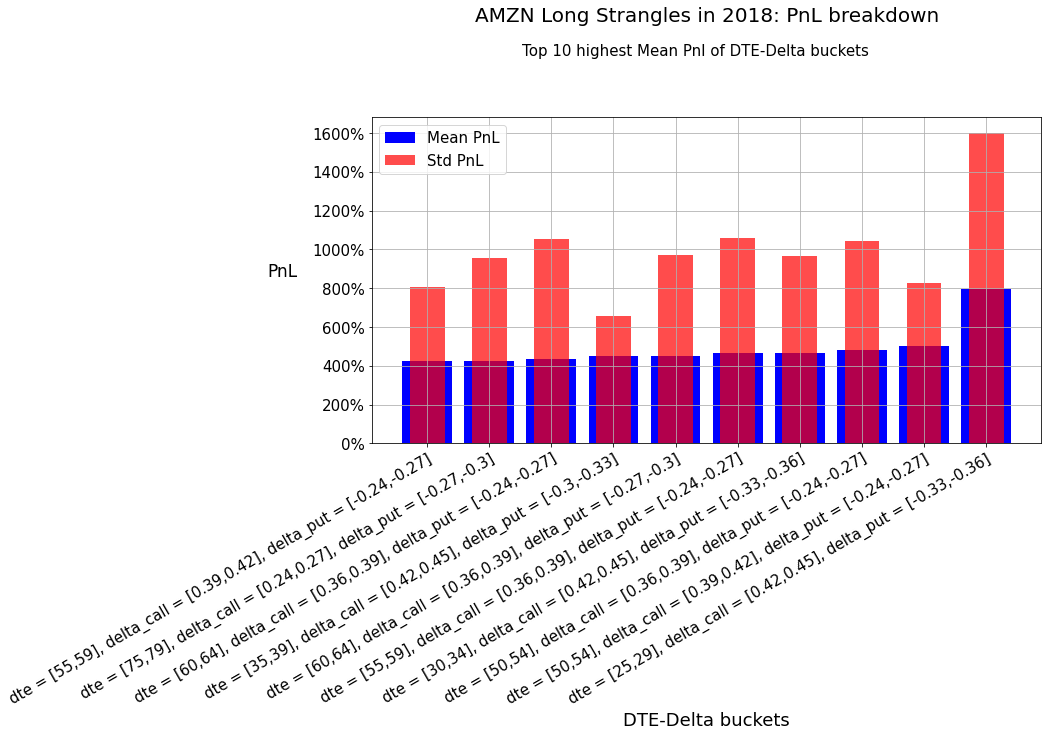

In [22]:
plt.title('AMZN Long Strangles in 2018: PnL breakdown',ha='center',fontsize=20, y=1.275)
plt.suptitle("Top 10 highest Mean Pnl of DTE-Delta buckets",ha='center',fontsize=15,y=1.05)

width=0.8
#plt.bar(delta_buckets_plot, mean_pnl_plot*100, yerr=std_pnl_plot*100, 
#        width=width, color='b', label='Mean PnL',ecolor="r", capsize=10)

plt.bar(delta_buckets_plot, mean_pnl_plot*100,
        width=width, color='b', label='Mean PnL', capsize=10)
plt.bar(delta_buckets_plot, std_pnl_plot*100, 
        width=width*0.7, color='r', alpha=0.7, label='Std PnL', capsize=10)


plt.xticks(rotation=30, horizontalalignment='right', rotation_mode='anchor')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.xlabel("DTE-Delta buckets",fontsize=18)
plt.ylabel("PnL",fontsize=17,rotation=0,labelpad=30)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.grid()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
try:
    os.mkdir("./"+Ticker+"/Figures/")
except:
    pass
plt.rcParams["figure.figsize"] = (14,6)
plt.title(Ticker+" overall",ha='center',fontsize=20, y=1.275)
# plt.suptitle("        Managed                                 Unmanaged   \n     Mean PnL: %1.2f%%                             Mean PnL: %1.2f%%   \n        Max Pain: %1.2f%%                            Max Pain: %1.2f%%\n "
#           %(100*np.mean(PnL_managed),100*np.mean(PnL_unmanaged),100*np.mean(Max_pain_managed),100*np.mean(Max_pain_unmanaged)),ha='center',fontsize=15,y=1.01)
plt.suptitle("     Managed:                                          Unmanaged:   \n\n     Mean PnL: %1.2f%%                             Mean PnL: %1.2f%%   \n      Max Pain: %1.2f%%                             Max Pain: %1.2f%%\n "
          %(100*np.mean(PnL_managed),100*np.mean(PnL_unmanaged),100*np.mean(Max_pain_managed),100*np.mean(Max_pain_unmanaged)),ha='center',fontsize=15,y=1.05)
import matplotlib.ticker as mtick
width=0.8
EXP1=list(PnL_by_year.keys())
plt.bar(EXP1,100*Managed_mean,width=width,
        color='b', label='Managed Position PnL')
plt.bar(EXP1,100*Unmanaged_mean,width=0.7*width,alpha=0.5,
        color='r', label='Unmanaged Position PnL')
plt.bar(EXP1,100*Managed_max_pain_mean,width=0.5*width, color='g', alpha=0.3, label='Managed Position Max Pain')
plt.bar(EXP1,100*Unmanaged_max_pain__mean,width=0.3*width, color='k', alpha=0.1, label='Unmanaged Position Max Pain')
plt.ylabel("PnL",fontsize=17,rotation=0,labelpad=30)
plt.xticks(rotation=30)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.xlabel("Year",fontsize=18)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.grid()
plt.savefig("./"+Ticker+"/Figures/"+Ticker+"_overall.png",dpi=300,bbox_inches='tight')
plt.close()
################################################################

In [ ]:
for i_day, day in enumerate(list(res.portfolios.keys())):
    for i_key, key_group in enumerate(list(res.portfolios[day].keys())):
        if len(res.portfolios[day][key_group])>0:
            list_maturity_buckets_card.append(len(res.portfolios[day][key_group]))
            list_maturity_buckets.append(key_group)

In [ ]:
np.unique(list_maturity_buckets)

In [ ]:
plt.plot(list_maturity_buckets_card)

In [ ]:
for i_day, day in enumerate(list(res.portfolios.keys())[:100]):
    for i_key, key_group in enumerate(list(res.portfolios[day].keys())):
        
        print("day = {}, key_group = {}".format(day, key_group))
        
        #for i_e, e in enumerate(res.portfolios[day][key_group][:1]):
        pnl = 0
        for i_e, e in enumerate(res.portfolios[day][key_group]):    
            
            #print(res.df.at[e[0],"option_type"],
            #      res.df.at[e[0],"delta"],
            #      res.df.at[e[1],"option_type"],
            #      res.df.at[e[1],"delta"],)
            
            
            #print(i_e, int(e[-1]*10000)/10000)
            
            pnl += e[-1] / (res.df.at[e[0], "ask"] + res.df.at[e[1], "ask"])
        print(pnl)
            
        print("-----------------------------------")

In [ ]:
day = trading_days[31]
key = list(res.portfolios[day].keys())[3]
print(key)
index_call = res.portfolios[day][key][0][0]
index_put = res.portfolios[day][key][0][1]
print(index_call, index_put)
print("Pnl = {}".format(res.portfolios[day][key][0][-1]))

In [ ]:
expiration = df.at[index_call, "expiration"]
strike_c = df.at[index_call, "strike"]
strike_p = df.at[index_put, "strike"]
portfolio_cost = abs(df.at[index_call, "ask"] + df.at[index_put, "ask"])


dfC_contract = df[(df.expiration==expiration)&(df.strike==strike_c)&(df.option_type=="C")].copy()
dfC_contract["intrinsic_value"] = np.maximum(dfC_contract["underlying_mid"] - dfC_contract["strike"], 0)
dfP_contract = df[(df.expiration==expiration)&(df.strike==strike_p)&(df.option_type=="P")].copy()
dfP_contract["intrinsic_value"] = np.maximum(dfP_contract["strike"] - dfP_contract["underlying_mid"], 0)


dfC_contract = dfC_contract[["quote_datetime", "underlying_mid", "ask", "strike", "intrinsic_value"]].reset_index().set_index(["quote_datetime", "underlying_mid"])
dfP_contract = dfP_contract[["quote_datetime", "underlying_mid", "ask", "strike", "intrinsic_value"]].reset_index().set_index(["quote_datetime", "underlying_mid"])
lsuffix, rsuffix = ("_"+str(k) for k in res.strategy.keys())
df_contract = dfC_contract.join(dfP_contract, lsuffix=lsuffix, rsuffix=rsuffix).reset_index()
print(df_contract.head())

df_contract["PnL"] = ((-portfolio_cost+df_contract.intrinsic_value_p+df_contract.intrinsic_value_c)
                      /portfolio_cost*100)

plt.plot(df_contract.quote_datetime, df_contract.PnL)

In [ ]:
print(res.portfolios[trading_days[0]].keys())

In [ ]:
day = trading_days[41]
key = list(res.portfolios[day].keys())[2]
print(key)

initial_cost_all = 0
pnl_all = []


for i_contract in range(len(res.portfolios[day][key])):
    index_call = res.portfolios[day][key][i_contract][0]
    index_put = res.portfolios[day][key][i_contract][1]
    #print(index_call, index_put)
    #print("Pnl = {}".format(res.portfolios[day][key][0][-1]))
    
    expiration = df.at[index_call, "expiration"]
    strike_c = df.at[index_call, "strike"]
    strike_p = df.at[index_put, "strike"]
    portfolio_cost = abs(df.at[index_call, "ask"] + df.at[index_put, "ask"])
    
    initial_cost_all -= portfolio_cost
    
    
    dfC_contract = df[(df.expiration==expiration)&(df.strike==strike_c)&(df.option_type=="C")].copy()
    dfC_contract["intrinsic_value"] = np.maximum(dfC_contract["underlying_mid"] - dfC_contract["strike"], 0)
    dfP_contract = df[(df.expiration==expiration)&(df.strike==strike_p)&(df.option_type=="P")].copy()
    dfP_contract["intrinsic_value"] = np.maximum(dfP_contract["strike"] - dfP_contract["underlying_mid"], 0)
    
    
    dfC_contract = dfC_contract[["quote_datetime", "underlying_mid", "ask", "intrinsic_value"]].reset_index().set_index(["quote_datetime", "underlying_mid"])
    dfP_contract = dfP_contract[["quote_datetime", "underlying_mid", "ask", "intrinsic_value"]].reset_index().set_index(["quote_datetime", "underlying_mid"])
    lsuffix, rsuffix = ("_"+str(k) for k in res.strategy.keys())
    df_contract = dfC_contract.join(dfP_contract, lsuffix=lsuffix, rsuffix=rsuffix).reset_index()
    
    df_contract["PnL"] = ((-portfolio_cost+df_contract.intrinsic_value_p+df_contract.intrinsic_value_c)
                          /portfolio_cost*100)
    
    pnl_all.append(df_contract.intrinsic_value_p+df_contract.intrinsic_value_c)
    
    plt.plot(df_contract.quote_datetime, df_contract.PnL)

In [ ]:
plt.plot(df_contract.quote_datetime, np.array(pnl_all).sum(axis=0)-initial_cost_all)

# trailing exit

In [ ]:
def trailing_exit(pnl_series, step_up, step_down, i_step_min):
    i_step = 1
    for i, pnl in enumerate(pnl_series):
        #print(i_step)
        if pnl > step_up*i_step:
            i_step += (pnl - step_up*i_step)//step_up+1
        elif i_step >= i_step_min+1 and pnl < step_up*(i_step-1) - step_down:
            return i, pnl
    return i, pnl_series[-1]


def trailing_low(pnl_series, step_up, step_down, i_step_min):
    res = np.zeros(len(pnl_series))
    i_step = 1
    for i, pnl in enumerate(pnl_series):
        if pnl > step_up*i_step:
            i_step += (pnl - step_up*i_step)//step_up+1
            res[i:] = (i_step-1)*step_up - step_down
    return res

def trailing_up(pnl_series, step_up, step_down, i_step_min):
    res = np.zeros(len(pnl_series))
    i_step = 1
    for i, pnl in enumerate(pnl_series):
        if pnl > step_up*i_step:
            i_step += (pnl - step_up*i_step)//step_up+1
        res[i:] = max(i_step, 1)*step_up
    return res

In [ ]:
path = (np.random.rand(200)*20-9).cumsum()
plt.plot(path)

step = 20
out = 10
return_min = 3

i_stop, pnl_stop = trailing_exit(path, step, out, return_min)

plt.plot([i_stop], [pnl_stop], "r.", label="exit")
plt.plot(trailing_low(path, step, out, return_min), ":", label="lower")
plt.plot(trailing_up(path, step, out, return_min), ":", label="upper")
plt.legend()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
try:
    os.mkdir("./"+Ticker+"/Figures/")
except:
    pass
plt.rcParams["figure.figsize"] = (14,6)
plt.title(Ticker+" overall",ha='center',fontsize=20, y=1.275)
plt.suptitle("        Managed                                 Unmanaged   \n     Mean PnL: %1.2f%%                             Mean PnL: %1.2f%%   \n        Max Pain: %1.2f%%                            Max Pain: %1.2f%%\n "
          %(100*np.mean(PnL_managed),100*np.mean(PnL_unmanaged),100*np.mean(Max_pain_managed),100*np.mean(Max_pain_unmanaged)),ha='center',fontsize=15,y=1.01)
plt.suptitle("     Managed:                                          Unmanaged:   \n\n     Mean PnL: %1.2f%%                             Mean PnL: %1.2f%%   \n      Max Pain: %1.2f%%                             Max Pain: %1.2f%%\n "
          %(100*np.mean(PnL_managed),100*np.mean(PnL_unmanaged),100*np.mean(Max_pain_managed),100*np.mean(Max_pain_unmanaged)),ha='center',fontsize=15,y=1.05)
import matplotlib.ticker as mtick
width=0.8
EXP1=list(PnL_by_year.keys())
plt.bar(EXP1,100*Managed_mean,width=width,
        color='b', label='Managed Position PnL')
plt.bar(EXP1,100*Unmanaged_mean,width=0.7*width,alpha=0.5,
        color='r', label='Unmanaged Position PnL')
plt.bar(EXP1,100*Managed_max_pain_mean,width=0.5*width, color='g', alpha=0.3, label='Managed Position Max Pain')
plt.bar(EXP1,100*Unmanaged_max_pain__mean,width=0.3*width, color='k', alpha=0.1, label='Unmanaged Position Max Pain')
plt.ylabel("PnL",fontsize=17,rotation=0,labelpad=30)
plt.xticks(rotation=30)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.xlabel("Year",fontsize=18)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.grid()
plt.savefig("./"+Ticker+"/Figures/"+Ticker+"_overall.png",dpi=300,bbox_inches='tight')
plt.close()
################################################################